# Zernike Polynomials Tutorial

This tutorial covers the Zernike polynomial functions in Janssen for optical aberration modeling.

## Overview

Zernike polynomials form a complete orthogonal basis over the unit circle and are widely used in optics to describe wavefront aberrations. They are particularly useful because:

1. They are orthogonal over the unit circle (pupil)
2. Each polynomial corresponds to a classical optical aberration
3. They provide a systematic way to decompose and analyze wavefront errors

## Indexing Conventions

Zernike polynomials can be indexed in two ways:

- **(n, m) indices**: `n` is the radial order, `m` is the azimuthal frequency
- **Noll index (j)**: A single index starting from j=1 (piston)

| Noll j | (n, m) | Name |
|--------|--------|------|
| 1 | (0, 0) | Piston |
| 2 | (1, 1) | Tilt X |
| 3 | (1, -1) | Tilt Y |
| 4 | (2, 0) | Defocus |
| 5 | (2, -2) | Astigmatism (oblique) |
| 6 | (2, 2) | Astigmatism (vertical) |
| 7 | (3, -1) | Coma Y |
| 8 | (3, 1) | Coma X |
| 9 | (3, -3) | Trefoil Y |
| 10 | (3, 3) | Trefoil X |
| 11 | (4, 0) | Spherical |

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from janssen.optics import (
    zernike_polynomial,
    zernike_radial,
    noll_to_nm,
    nm_to_noll,
)

## Setup: Coordinate Grids

Zernike polynomials are defined on the unit circle using polar coordinates (rho, theta).

In [2]:
# Create coordinate grids
grid_size = 256
x = jnp.linspace(-1.2, 1.2, grid_size)
y = jnp.linspace(-1.2, 1.2, grid_size)
xx, yy = jnp.meshgrid(x, y)

# Convert to polar coordinates
rho = jnp.sqrt(xx**2 + yy**2)
theta = jnp.arctan2(yy, xx)

# Mask for unit circle visualization
circle_mask = rho <= 1.0

## 1. Index Conversion Functions

Convert between Noll indexing and (n, m) indices.

In [3]:
# Convert Noll index to (n, m)
print("Noll to (n, m) conversion:")
print("-" * 30)
for j in range(1, 16):
    n, m = noll_to_nm(j)
    print(f"j={j:2d} -> (n={n}, m={m:2d})")

Noll to (n, m) conversion:
------------------------------
j= 1 -> (n=0, m= 0)
j= 2 -> (n=1, m= 1)
j= 3 -> (n=1, m=-1)
j= 4 -> (n=2, m= 0)
j= 5 -> (n=2, m=-2)
j= 6 -> (n=2, m= 2)
j= 7 -> (n=3, m=-1)
j= 8 -> (n=3, m= 1)
j= 9 -> (n=3, m=-3)
j=10 -> (n=3, m= 3)
j=11 -> (n=4, m= 0)
j=12 -> (n=4, m= 2)
j=13 -> (n=4, m=-2)
j=14 -> (n=4, m= 4)
j=15 -> (n=4, m=-4)


In [4]:
# Convert (n, m) to Noll index
print("\n(n, m) to Noll conversion:")
print("-" * 30)
test_cases = [(0, 0), (1, 1), (1, -1), (2, 0), (2, 2), (2, -2), (3, 1), (3, -1), (4, 0)]
for n, m in test_cases:
    j = nm_to_noll(n, m)
    print(f"(n={n}, m={m:2d}) -> j={j}")


(n, m) to Noll conversion:
------------------------------
(n=0, m= 0) -> j=1
(n=1, m= 1) -> j=2
(n=1, m=-1) -> j=3
(n=2, m= 0) -> j=4
(n=2, m= 2) -> j=6
(n=2, m=-2) -> j=5
(n=3, m= 1) -> j=8
(n=3, m=-1) -> j=7
(n=4, m= 0) -> j=11


## 2. Radial Polynomials

The radial component $R_n^{|m|}(\rho)$ depends only on the radial coordinate.

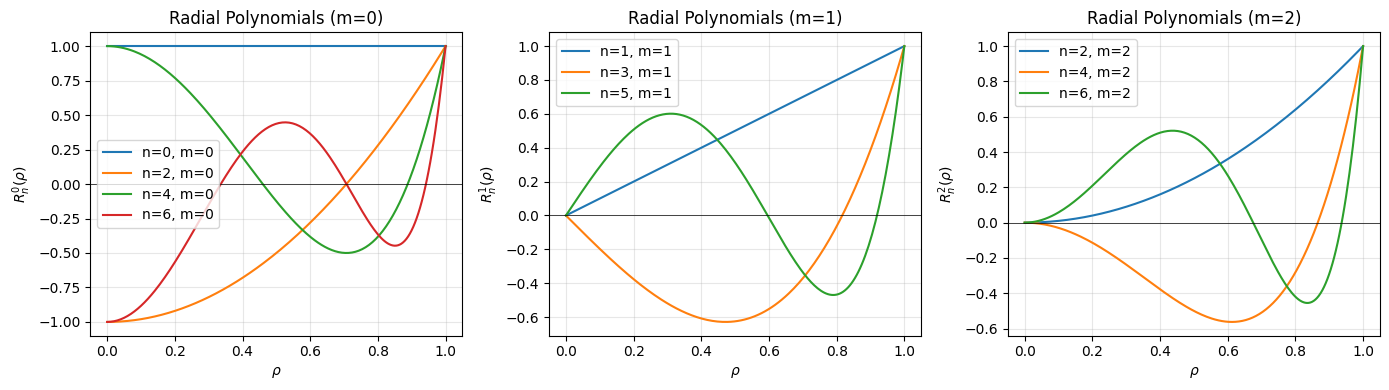

In [5]:
# Plot radial polynomials for different (n, m) combinations
rho_1d = jnp.linspace(0, 1, 200)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# m = 0 (rotationally symmetric)
ax = axes[0]
for n in [0, 2, 4, 6]:
    R = zernike_radial(rho_1d, n, 0)
    ax.plot(rho_1d, R, label=f"n={n}, m=0")
ax.set_xlabel(r"$\rho$")
ax.set_ylabel(r"$R_n^0(\rho)$")
ax.set_title("Radial Polynomials (m=0)")
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linewidth=0.5)

# m = 1
ax = axes[1]
for n in [1, 3, 5]:
    R = zernike_radial(rho_1d, n, 1)
    ax.plot(rho_1d, R, label=f"n={n}, m=1")
ax.set_xlabel(r"$\rho$")
ax.set_ylabel(r"$R_n^1(\rho)$")
ax.set_title("Radial Polynomials (m=1)")
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linewidth=0.5)

# m = 2
ax = axes[2]
for n in [2, 4, 6]:
    R = zernike_radial(rho_1d, n, 2)
    ax.plot(rho_1d, R, label=f"n={n}, m=2")
ax.set_xlabel(r"$\rho$")
ax.set_ylabel(r"$R_n^2(\rho)$")
ax.set_title("Radial Polynomials (m=2)")
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linewidth=0.5)

plt.tight_layout()
plt.show()

## 3. Individual Zernike Polynomials

Generate and visualize individual Zernike polynomials using either (n, m) or Noll indexing.

In [6]:
def plot_zernike(rho, theta, n, m, ax, title=None):
    """Plot a single Zernike polynomial."""
    Z = zernike_polynomial(rho, theta, n, m, normalize=True)
    # Mask outside unit circle for display
    Z_masked = jnp.where(rho <= 1.0, Z, jnp.nan)
    
    vmax = jnp.nanmax(jnp.abs(Z_masked))
    im = ax.imshow(Z_masked, cmap="RdBu_r", vmin=-vmax, vmax=vmax, extent=[-1.2, 1.2, -1.2, 1.2])
    ax.set_aspect("equal")
    ax.axis("off")
    
    if title is None:
        j = nm_to_noll(n, m)
        title = f"Z{j} (n={n}, m={m})"
    ax.set_title(title)
    return im

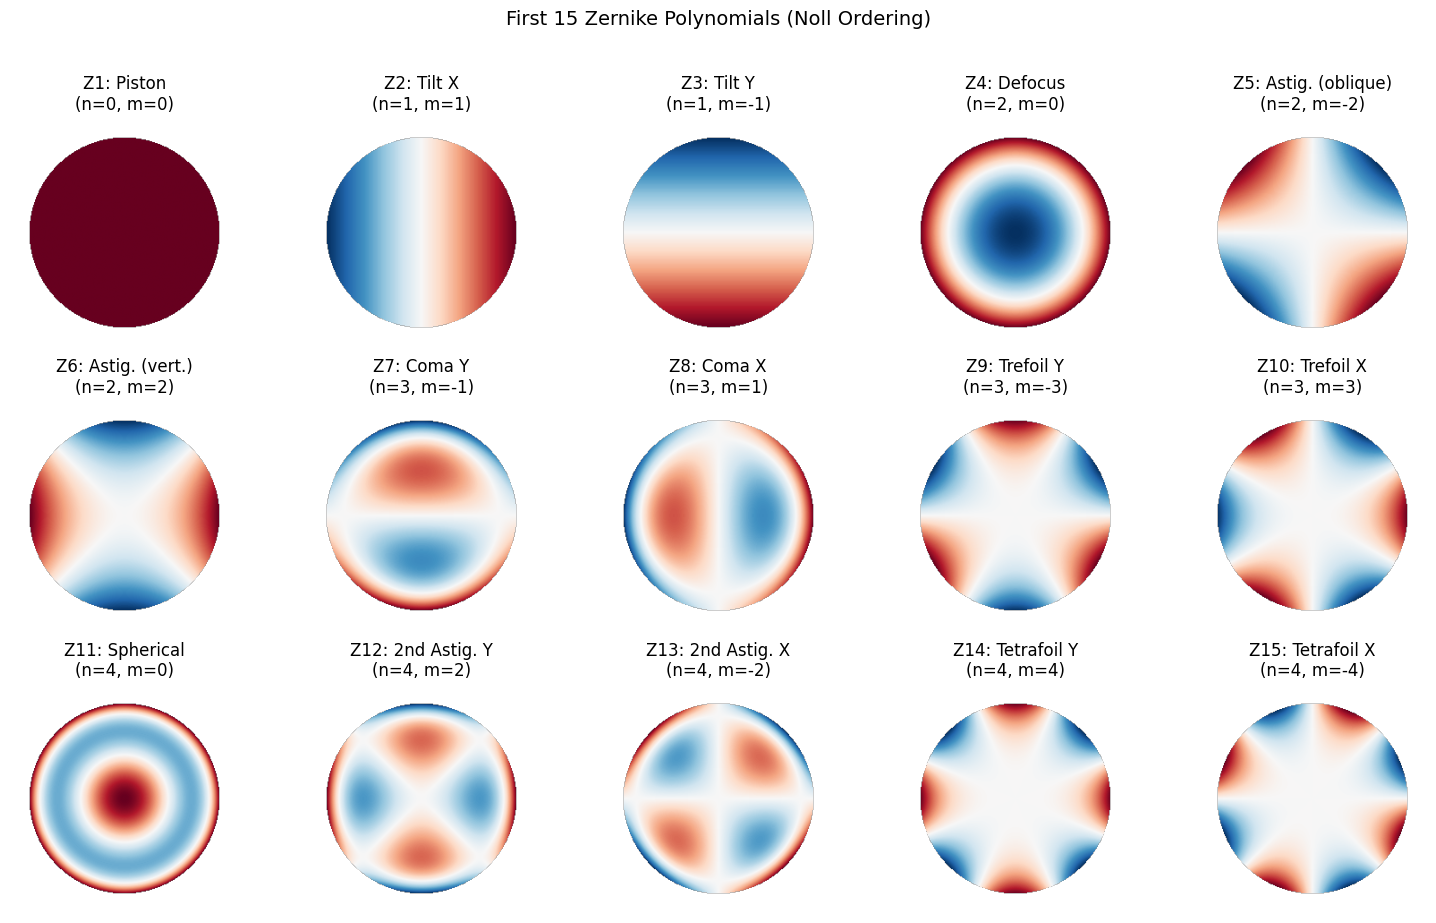

In [7]:
# Plot first 15 Zernike polynomials (Noll ordering)
fig, axes = plt.subplots(3, 5, figsize=(15, 9))

aberration_names = {
    1: "Piston",
    2: "Tilt X",
    3: "Tilt Y",
    4: "Defocus",
    5: "Astig. (oblique)",
    6: "Astig. (vert.)",
    7: "Coma Y",
    8: "Coma X",
    9: "Trefoil Y",
    10: "Trefoil X",
    11: "Spherical",
    12: "2nd Astig. Y",
    13: "2nd Astig. X",
    14: "Tetrafoil Y",
    15: "Tetrafoil X",
}

for idx, j in enumerate(range(1, 16)):
    ax = axes.flat[idx]
    n, m = noll_to_nm(j)
    n, m = int(n), int(m)  # Ensure Python int (n,m are static shape parameters)
    name = aberration_names.get(j, "")
    title = f"Z{j}: {name}\n(n={n}, m={m})"
    plot_zernike(rho, theta, n, m, ax, title=title)

plt.suptitle("First 15 Zernike Polynomials (Noll Ordering)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 4. Zernike Pyramid

Zernike polynomials organized by radial order n and azimuthal frequency m.

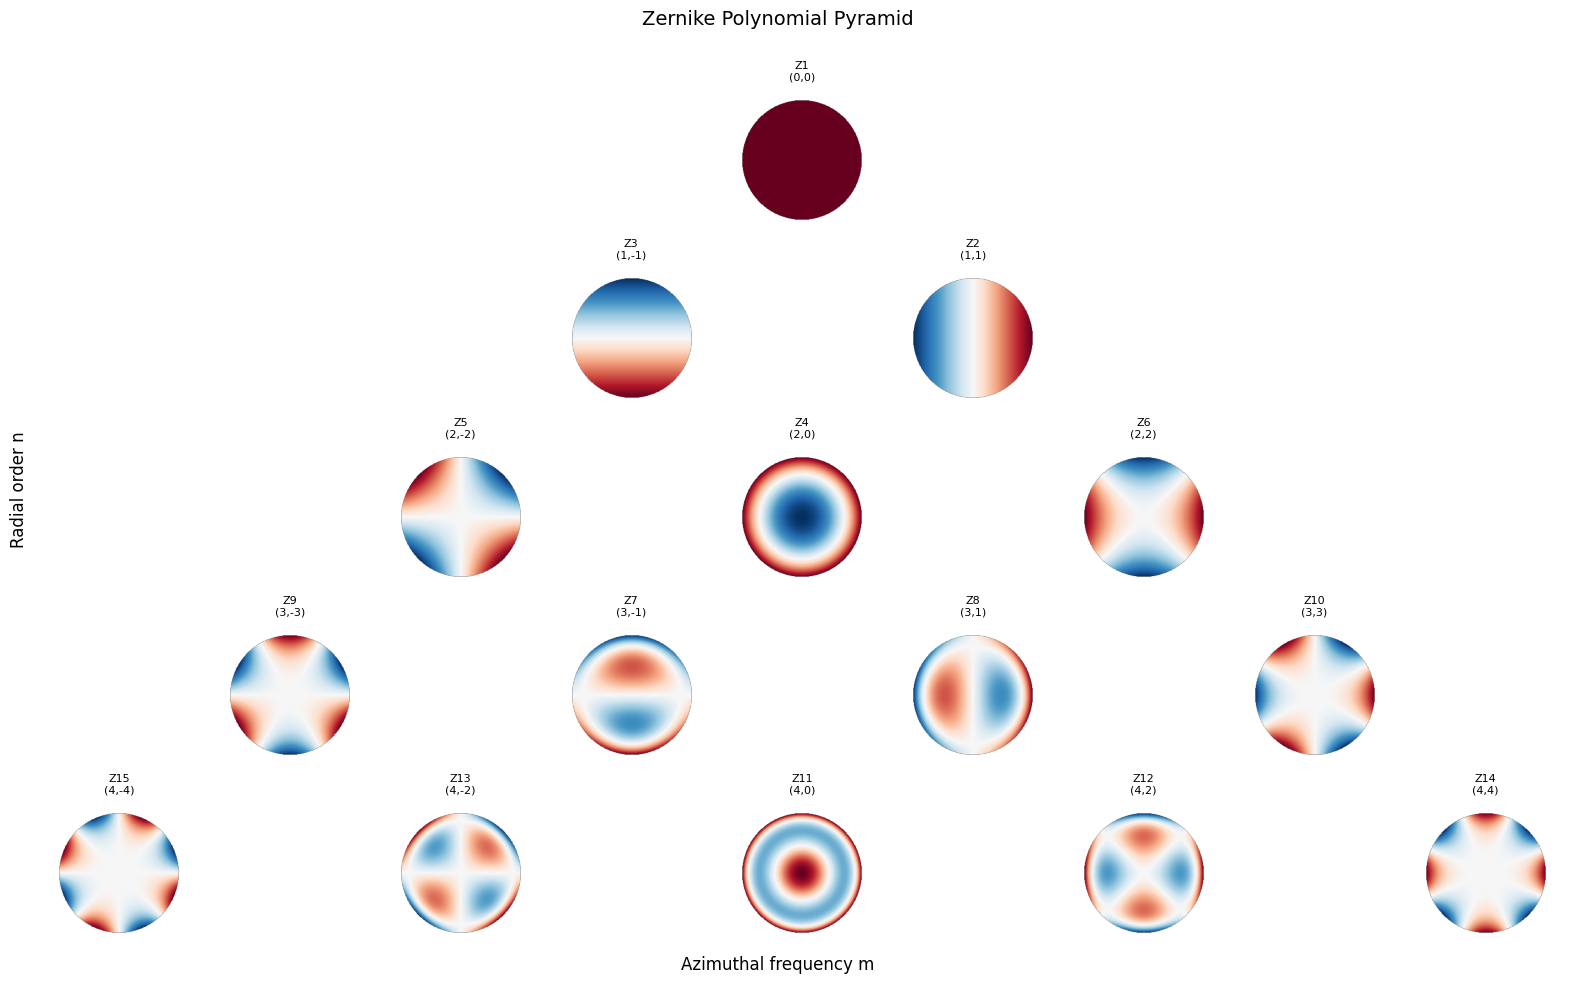

In [8]:
# Create Zernike pyramid up to n=4
max_n = 4

fig, axes = plt.subplots(max_n + 1, 2 * max_n + 1, figsize=(16, 10))

# Hide all axes initially
for ax_row in axes:
    for ax in ax_row:
        ax.axis("off")

# Plot Zernike polynomials in pyramid arrangement
for n in range(max_n + 1):
    # Valid m values for this n: -n, -n+2, ..., n-2, n (same parity as n)
    m_values = list(range(-n, n + 1, 2))
    
    for m in m_values:
        # Calculate column position (centered)
        col = max_n + m
        ax = axes[n, col]
        
        Z = zernike_polynomial(rho, theta, n, m, normalize=True)
        Z_masked = jnp.where(rho <= 1.0, Z, jnp.nan)
        
        vmax = jnp.nanmax(jnp.abs(Z_masked))
        if vmax > 0:
            ax.imshow(Z_masked, cmap="RdBu_r", vmin=-vmax, vmax=vmax)
        else:
            ax.imshow(Z_masked, cmap="RdBu_r")
        
        j = nm_to_noll(n, m)
        ax.set_title(f"Z{j}\n({n},{m})", fontsize=8)
        ax.axis("off")

# Add labels
fig.text(0.02, 0.5, "Radial order n", va="center", rotation="vertical", fontsize=12)
fig.text(0.5, 0.02, "Azimuthal frequency m", ha="center", fontsize=12)

plt.suptitle("Zernike Polynomial Pyramid", fontsize=14)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.97])
plt.show()

## 5. Common Optical Aberrations

Janssen provides convenience functions for common aberrations.

In [9]:
# Physical coordinate setup
pupil_radius = 1.0  # meters (normalized)
physical_extent = 1.2 * pupil_radius

x_phys = jnp.linspace(-physical_extent, physical_extent, grid_size)
y_phys = jnp.linspace(-physical_extent, physical_extent, grid_size)
xx_phys, yy_phys = jnp.meshgrid(x_phys, y_phys)

# Mask for visualization
rho_phys = jnp.sqrt(xx_phys**2 + yy_phys**2) / pupil_radius

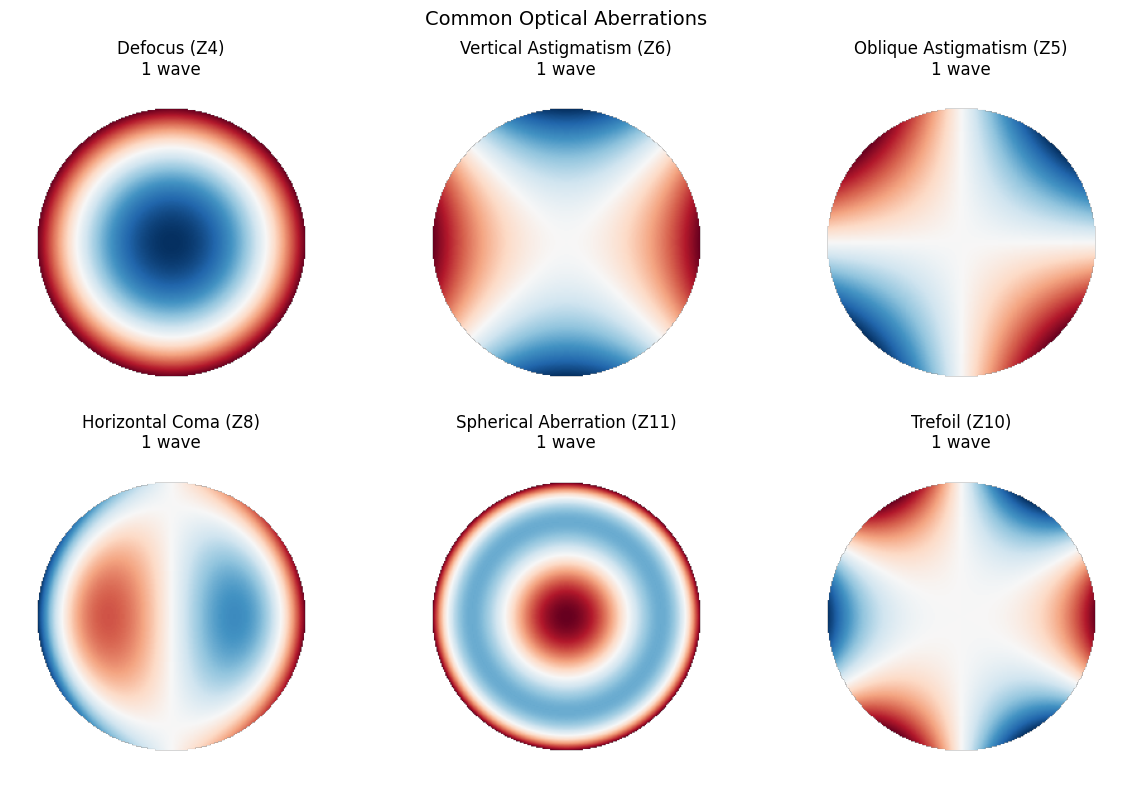

In [10]:
def plot_aberration(phase, title, ax):
    """Plot an aberration phase map."""
    phase_masked = jnp.where(rho_phys <= 1.0, phase, jnp.nan)
    vmax = jnp.nanmax(jnp.abs(phase_masked))
    if vmax > 0:
        im = ax.imshow(phase_masked, cmap="RdBu_r", vmin=-vmax, vmax=vmax)
    else:
        im = ax.imshow(phase_masked, cmap="RdBu_r")
    ax.set_title(title)
    ax.axis("off")
    return im


def make_aberration(n, m, amplitude):
    """Generate aberration phase using zernike_polynomial directly."""
    Z = zernike_polynomial(rho_phys, jnp.arctan2(yy_phys, xx_phys), n, m, normalize=True)
    return 2 * jnp.pi * amplitude * Z


fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Defocus (Z4): n=2, m=0
phase_defocus = make_aberration(2, 0, 1.0)
plot_aberration(phase_defocus, "Defocus (Z4)\n1 wave", axes[0, 0])

# Vertical Astigmatism (Z6): n=2, m=2
phase_astig = make_aberration(2, 2, 1.0)
plot_aberration(phase_astig, "Vertical Astigmatism (Z6)\n1 wave", axes[0, 1])

# Oblique Astigmatism (Z5): n=2, m=-2
phase_astig_45 = make_aberration(2, -2, 1.0)
plot_aberration(phase_astig_45, "Oblique Astigmatism (Z5)\n1 wave", axes[0, 2])

# Horizontal Coma (Z8): n=3, m=1
phase_coma = make_aberration(3, 1, 1.0)
plot_aberration(phase_coma, "Horizontal Coma (Z8)\n1 wave", axes[1, 0])

# Spherical Aberration (Z11): n=4, m=0
phase_spherical = make_aberration(4, 0, 1.0)
plot_aberration(phase_spherical, "Spherical Aberration (Z11)\n1 wave", axes[1, 1])

# Trefoil (Z10): n=3, m=3
phase_trefoil = make_aberration(3, 3, 1.0)
plot_aberration(phase_trefoil, "Trefoil (Z10)\n1 wave", axes[1, 2])

plt.suptitle("Common Optical Aberrations", fontsize=14)
plt.tight_layout()
plt.show()

## 6. Generating Aberrations from Coefficients

Combine multiple Zernike modes to create complex wavefront aberrations.

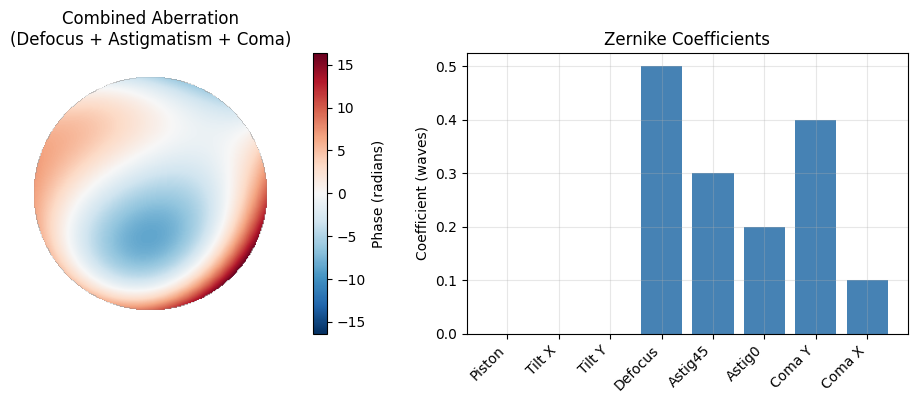

In [11]:
# Generate combined aberration by summing individual Zernike modes
# Using zernike_polynomial directly (the generate_aberration_noll function has a JAX tracing issue)

theta_phys = jnp.arctan2(yy_phys, xx_phys)

def generate_aberration_manual(rho, theta, noll_coeffs):
    """Generate aberration from Noll-indexed coefficients."""
    phase = jnp.zeros_like(rho)
    for j, coeff in enumerate(noll_coeffs, 1):
        if coeff != 0:
            n, m = noll_to_nm(j)
            n, m = int(n), int(m)
            Z = zernike_polynomial(rho, theta, n, m, normalize=True)
            phase = phase + coeff * Z
    return 2 * jnp.pi * phase

# Example: Combination of defocus + astigmatism + coma
coefficients_noll = [
    0.0,   # j=1: Piston
    0.0,   # j=2: Tilt X
    0.0,   # j=3: Tilt Y
    0.5,   # j=4: Defocus
    0.3,   # j=5: Astigmatism (oblique)
    0.2,   # j=6: Astigmatism (vertical)
    0.4,   # j=7: Coma Y
    0.1,   # j=8: Coma X
]

phase_combined = generate_aberration_manual(rho_phys, theta_phys, coefficients_noll)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot combined aberration
phase_masked = jnp.where(rho_phys <= 1.0, phase_combined, jnp.nan)
vmax = jnp.nanmax(jnp.abs(phase_masked))
im = axes[0].imshow(phase_masked, cmap="RdBu_r", vmin=-vmax, vmax=vmax)
axes[0].set_title("Combined Aberration\n(Defocus + Astigmatism + Coma)")
axes[0].axis("off")
plt.colorbar(im, ax=axes[0], label="Phase (radians)")

# Bar plot of coefficients
labels = ["Piston", "Tilt X", "Tilt Y", "Defocus", "Astig45", "Astig0", "Coma Y", "Coma X"]
colors = ["gray" if c == 0 else "steelblue" for c in coefficients_noll]
axes[1].bar(range(len(coefficients_noll)), coefficients_noll, color=colors)
axes[1].set_xticks(range(len(coefficients_noll)))
axes[1].set_xticklabels(labels, rotation=45, ha="right")
axes[1].set_ylabel("Coefficient (waves)")
axes[1].set_title("Zernike Coefficients")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

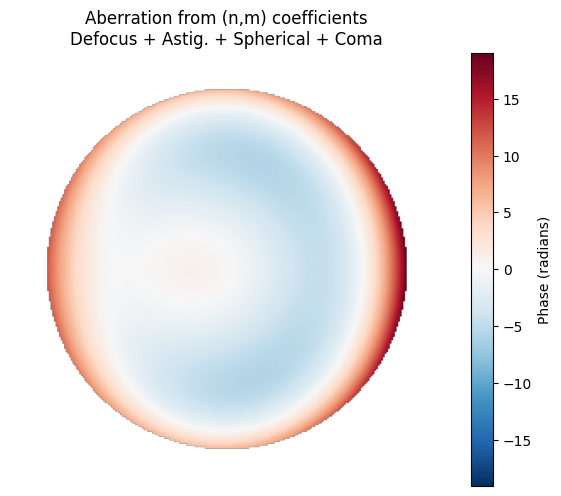

In [12]:
# Generate aberration using (n, m) indices directly
nm_specs = [
    (2, 0, 0.5),   # Defocus
    (2, 2, 0.3),   # Astigmatism
    (4, 0, 0.4),   # Spherical
    (3, 1, 0.2),   # Coma
]

phase_nm = jnp.zeros_like(rho_phys)
for n, m, coeff in nm_specs:
    Z = zernike_polynomial(rho_phys, theta_phys, n, m, normalize=True)
    phase_nm = phase_nm + coeff * Z
phase_nm = 2 * jnp.pi * phase_nm

# Visualize
fig, ax = plt.subplots(figsize=(6, 5))
phase_masked = jnp.where(rho_phys <= 1.0, phase_nm, jnp.nan)
vmax = jnp.nanmax(jnp.abs(phase_masked))
im = ax.imshow(phase_masked, cmap="RdBu_r", vmin=-vmax, vmax=vmax)
ax.set_title("Aberration from (n,m) coefficients\nDefocus + Astig. + Spherical + Coma")
ax.axis("off")
plt.colorbar(im, ax=ax, label="Phase (radians)")
plt.tight_layout()
plt.show()

## 7. Effect of Varying Coefficients

Visualize how aberrations change with varying amplitude.

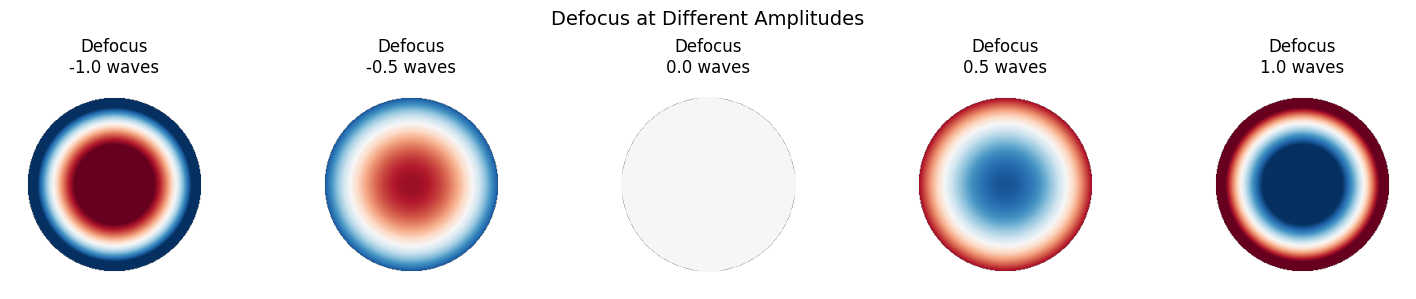

In [13]:
# Show defocus at different amplitudes
amplitudes = [-1.0, -0.5, 0.0, 0.5, 1.0]

fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for ax, amp in zip(axes, amplitudes):
    phase = make_aberration(2, 0, amp)  # n=2, m=0 for defocus
    phase_masked = jnp.where(rho_phys <= 1.0, phase, jnp.nan)
    ax.imshow(phase_masked, cmap="RdBu_r", vmin=-2*jnp.pi, vmax=2*jnp.pi)
    ax.set_title(f"Defocus\n{amp} waves")
    ax.axis("off")

plt.suptitle("Defocus at Different Amplitudes", fontsize=14)
plt.tight_layout()
plt.show()

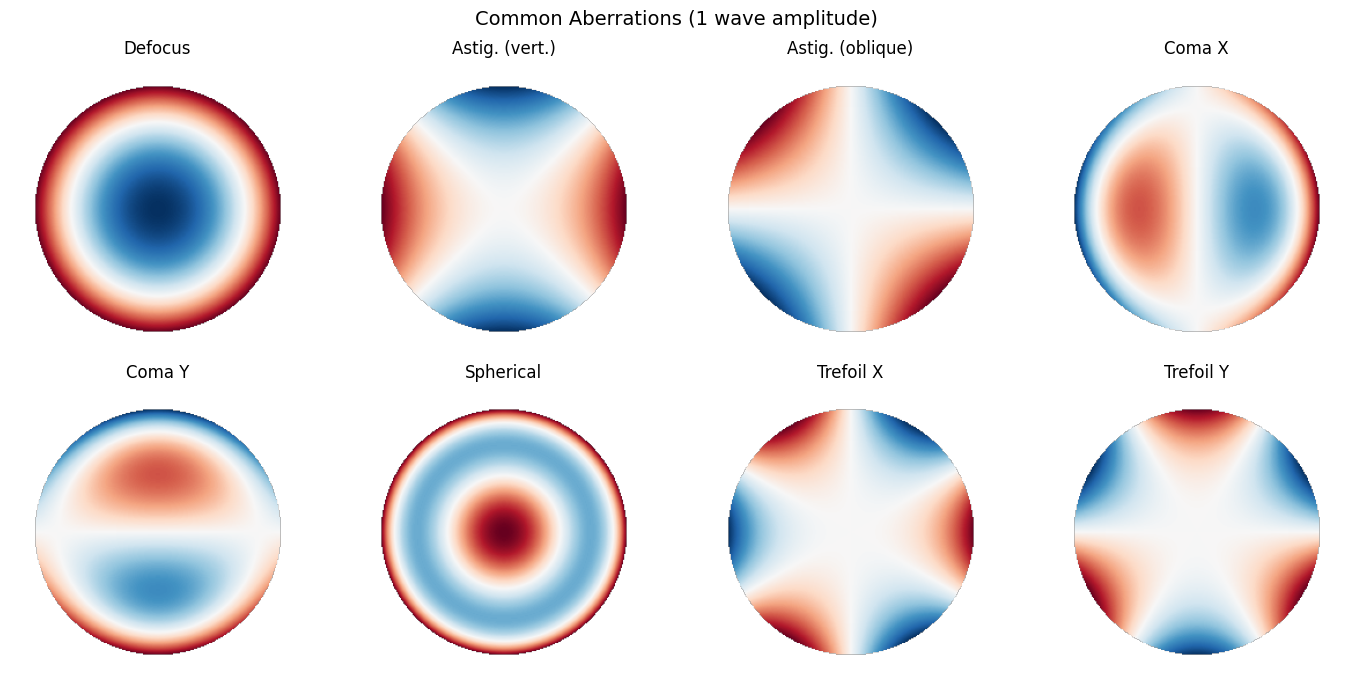

In [14]:
# Compare different aberration modes at same amplitude
fig, axes = plt.subplots(2, 4, figsize=(14, 7))

# (name, n, m)
aberrations = [
    ("Defocus", 2, 0),
    ("Astig. (vert.)", 2, 2),
    ("Astig. (oblique)", 2, -2),
    ("Coma X", 3, 1),
    ("Coma Y", 3, -1),
    ("Spherical", 4, 0),
    ("Trefoil X", 3, 3),
    ("Trefoil Y", 3, -3),
]

for ax, (name, n, m) in zip(axes.flat, aberrations):
    phase = make_aberration(n, m, 1.0)
    phase_masked = jnp.where(rho_phys <= 1.0, phase, jnp.nan)
    vmax = jnp.nanmax(jnp.abs(phase_masked))
    ax.imshow(phase_masked, cmap="RdBu_r", vmin=-vmax, vmax=vmax)
    ax.set_title(name)
    ax.axis("off")

plt.suptitle("Common Aberrations (1 wave amplitude)", fontsize=14)
plt.tight_layout()
plt.show()

## 8. Orthogonality of Zernike Polynomials

Zernike polynomials are orthogonal over the unit circle. The inner product of two different normalized Zernike polynomials is zero.

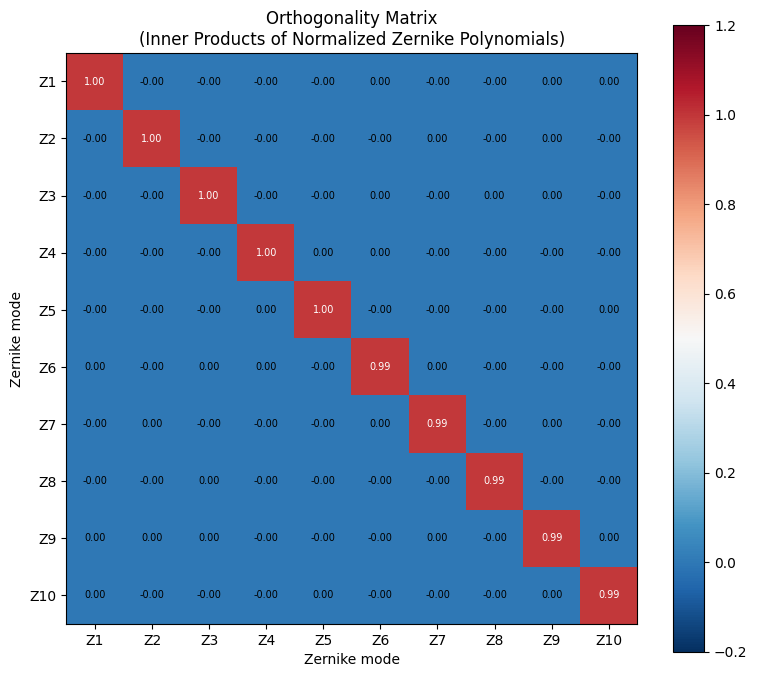

Diagonal values (should be ~1.0):
['0.996', '0.995', '0.995', '0.995', '0.996', '0.995', '0.995', '0.995', '0.995', '0.995']


In [15]:
# Create finer grid for numerical integration
n_points = 512
x_fine = jnp.linspace(-1, 1, n_points)
y_fine = jnp.linspace(-1, 1, n_points)
xx_fine, yy_fine = jnp.meshgrid(x_fine, y_fine)
rho_fine = jnp.sqrt(xx_fine**2 + yy_fine**2)
theta_fine = jnp.arctan2(yy_fine, xx_fine)

# Compute inner products for first 10 Zernike modes
n_modes = 10
inner_products = jnp.zeros((n_modes, n_modes))

# Generate all Zernike polynomials
zernike_modes = []
for j in range(1, n_modes + 1):
    n, m = noll_to_nm(j)
    n, m = int(n), int(m)  # Ensure Python int
    Z = zernike_polynomial(rho_fine, theta_fine, n, m, normalize=True)
    Z = jnp.where(rho_fine <= 1.0, Z, 0.0)
    zernike_modes.append(Z)

# Compute inner product matrix
dx = 2.0 / n_points
area_element = dx * dx
pupil_area = jnp.pi  # area of unit circle

inner_product_matrix = []
for i, Zi in enumerate(zernike_modes):
    row = []
    for j, Zj in enumerate(zernike_modes):
        # Inner product: integral of Zi * Zj over unit circle
        product = Zi * Zj
        integral = jnp.sum(product) * area_element / pupil_area
        row.append(float(integral))
    inner_product_matrix.append(row)

inner_product_matrix = jnp.array(inner_product_matrix)

# Plot
fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(inner_product_matrix, cmap="RdBu_r", vmin=-0.2, vmax=1.2)
ax.set_xticks(range(n_modes))
ax.set_yticks(range(n_modes))
ax.set_xticklabels([f"Z{j}" for j in range(1, n_modes + 1)])
ax.set_yticklabels([f"Z{j}" for j in range(1, n_modes + 1)])
ax.set_xlabel("Zernike mode")
ax.set_ylabel("Zernike mode")
ax.set_title("Orthogonality Matrix\n(Inner Products of Normalized Zernike Polynomials)")
plt.colorbar(im, ax=ax)

# Annotate values
for i in range(n_modes):
    for j in range(n_modes):
        val = inner_product_matrix[i, j]
        color = "white" if abs(val) > 0.5 else "black"
        ax.text(j, i, f"{val:.2f}", ha="center", va="center", color=color, fontsize=7)

plt.tight_layout()
plt.show()

print("Diagonal values (should be ~1.0):")
print([f"{inner_product_matrix[i,i]:.3f}" for i in range(n_modes)])

## 9. Random Aberrations

Generate random wavefront aberrations by sampling Zernike coefficients.

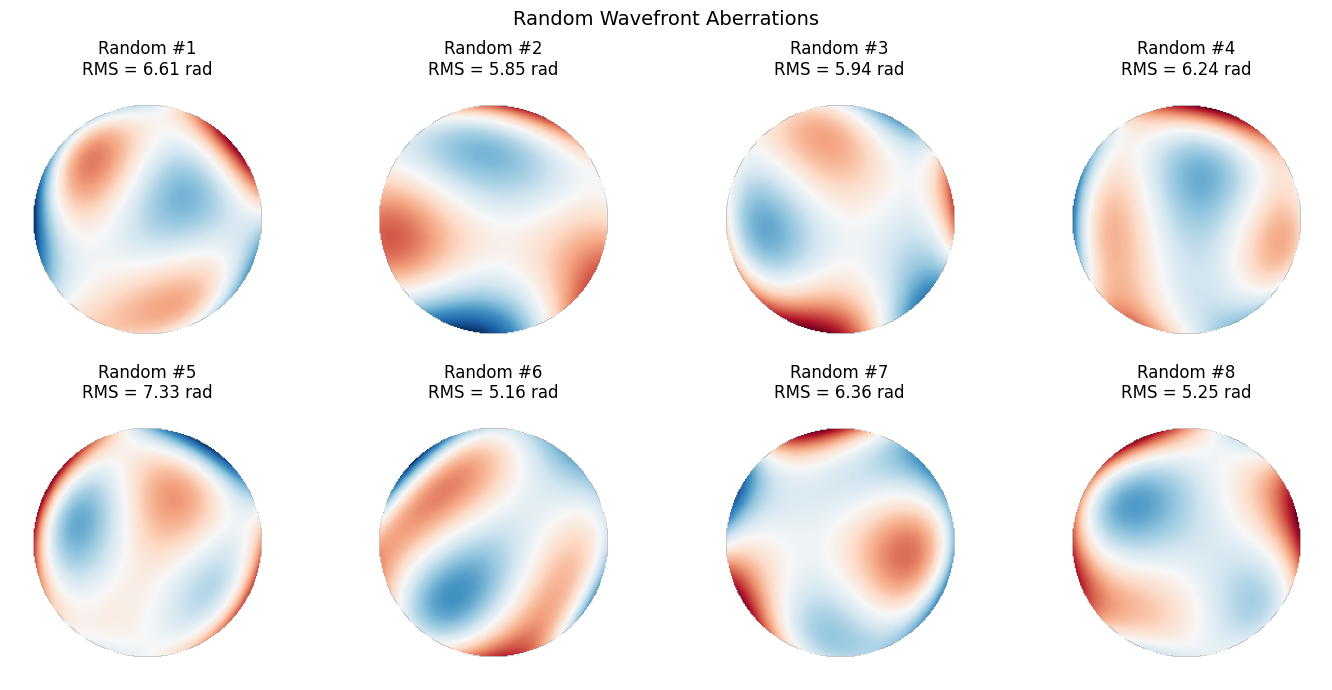

In [16]:
import jax

# Generate random aberrations
key = jax.random.PRNGKey(42)

fig, axes = plt.subplots(2, 4, figsize=(14, 7))

for idx, ax in enumerate(axes.flat):
    key, subkey = jax.random.split(key)
    
    # Random coefficients for Noll indices 4-15 (skip piston and tilts)
    n_coeffs = 15
    random_coeffs = jax.random.normal(subkey, (n_coeffs - 3,)) * 0.3
    
    # Build phase by summing individual modes
    phase = jnp.zeros_like(rho_phys)
    for i, coeff in enumerate(random_coeffs):
        j = i + 4  # Start from j=4 (defocus)
        n, m = noll_to_nm(j)
        n, m = int(n), int(m)
        Z = zernike_polynomial(rho_phys, theta_phys, n, m, normalize=True)
        phase = phase + coeff * Z
    phase = 2 * jnp.pi * phase
    
    phase_masked = jnp.where(rho_phys <= 1.0, phase, jnp.nan)
    
    vmax = jnp.nanmax(jnp.abs(phase_masked))
    ax.imshow(phase_masked, cmap="RdBu_r", vmin=-vmax, vmax=vmax)
    
    # Calculate RMS
    rms = jnp.sqrt(jnp.nanmean(phase_masked**2))
    ax.set_title(f"Random #{idx+1}\nRMS = {rms:.2f} rad")
    ax.axis("off")

plt.suptitle("Random Wavefront Aberrations", fontsize=14)
plt.tight_layout()
plt.show()

## 10. Differentiability

The Zernike polynomial functions are fully differentiable with JAX. This enables gradient-based analysis and optimization. Here we visualize gradients of aberration phase maps with respect to Zernike coefficients.

In [17]:
# Demonstrate differentiability by computing gradients of phase w.r.t. coefficients
# The gradient at each point is simply the Zernike polynomial value (scaled by 2*pi)

def compute_phase(coeffs, rho_val, theta_val):
    """Compute phase at a single point given Noll coefficients."""
    phase = 0.0
    for j in range(1, len(coeffs) + 1):
        n, m = noll_to_nm(j)
        n, m = int(n), int(m)
        Z = zernike_polynomial(
            jnp.array([rho_val]), 
            jnp.array([theta_val]), 
            n, m, normalize=True
        )[0]
        phase = phase + coeffs[j-1] * Z
    return 2 * jnp.pi * phase

# Compute gradient function
grad_phase = jax.grad(compute_phase)

# Evaluate gradient at center and at edge
coeffs_test = jnp.zeros(11)
coeffs_test = coeffs_test.at[3].set(0.5)  # Some defocus

grad_at_center = grad_phase(coeffs_test, 0.0, 0.0)
grad_at_edge = grad_phase(coeffs_test, 0.7, 0.0)

print("Gradient dPhase/dCoeff at center (rho=0):")
for j in range(1, 12):
    print(f"  Z{j:2d}: {grad_at_center[j-1]:+.4f}")

print("\nGradient dPhase/dCoeff at edge (rho=0.7, theta=0):")
for j in range(1, 12):
    print(f"  Z{j:2d}: {grad_at_edge[j-1]:+.4f}")

Gradient dPhase/dCoeff at center (rho=0):
  Z 1: +6.2832
  Z 2: +0.0000
  Z 3: +0.0000
  Z 4: -10.8828
  Z 5: +0.0000
  Z 6: +0.0000
  Z 7: +0.0000
  Z 8: +0.0000
  Z 9: +0.0000
  Z10: +0.0000
  Z11: +14.0496

Gradient dPhase/dCoeff at edge (rho=0.7, theta=0):
  Z 1: +6.2832
  Z 2: +8.7965
  Z 3: +0.0000
  Z 4: -0.2177
  Z 5: +0.0000
  Z 6: +7.5414
  Z 7: +0.0000
  Z 8: -6.5932
  Z 9: +0.0000
  Z10: +6.0956
  Z11: -7.0164


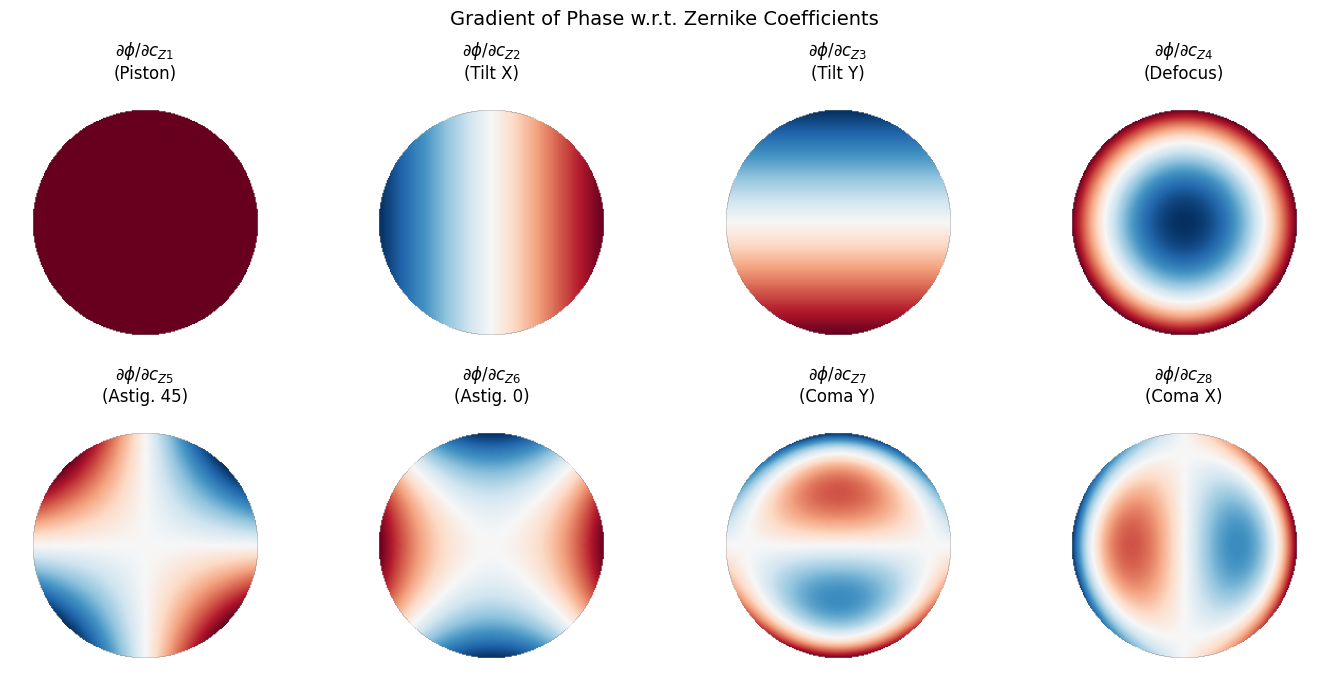

In [18]:
# Visualize gradient maps: how phase changes with each coefficient across the pupil
# The gradient dPhase/dCoeff_j is simply 2*pi * Z_j (the Zernike polynomial)

fig, axes = plt.subplots(2, 4, figsize=(14, 7))

mode_names = ["Piston", "Tilt X", "Tilt Y", "Defocus", 
              "Astig. 45", "Astig. 0", "Coma Y", "Coma X"]

for idx, ax in enumerate(axes.flat):
    j = idx + 1  # Noll index
    n, m = noll_to_nm(j)
    n, m = int(n), int(m)
    
    # Gradient is 2*pi * normalized Zernike polynomial
    grad_map = 2 * jnp.pi * zernike_polynomial(rho_phys, theta_phys, n, m, normalize=True)
    grad_masked = jnp.where(rho_phys <= 1.0, grad_map, jnp.nan)
    
    vmax = jnp.nanmax(jnp.abs(grad_masked))
    if vmax > 0:
        im = ax.imshow(grad_masked, cmap="RdBu_r", vmin=-vmax, vmax=vmax)
    else:
        im = ax.imshow(grad_masked, cmap="RdBu_r")
    
    ax.set_title(f"$\\partial\\phi / \\partial c_{{Z{j}}}$\n({mode_names[idx]})")
    ax.axis("off")

plt.suptitle("Gradient of Phase w.r.t. Zernike Coefficients", fontsize=14)
plt.tight_layout()
plt.show()

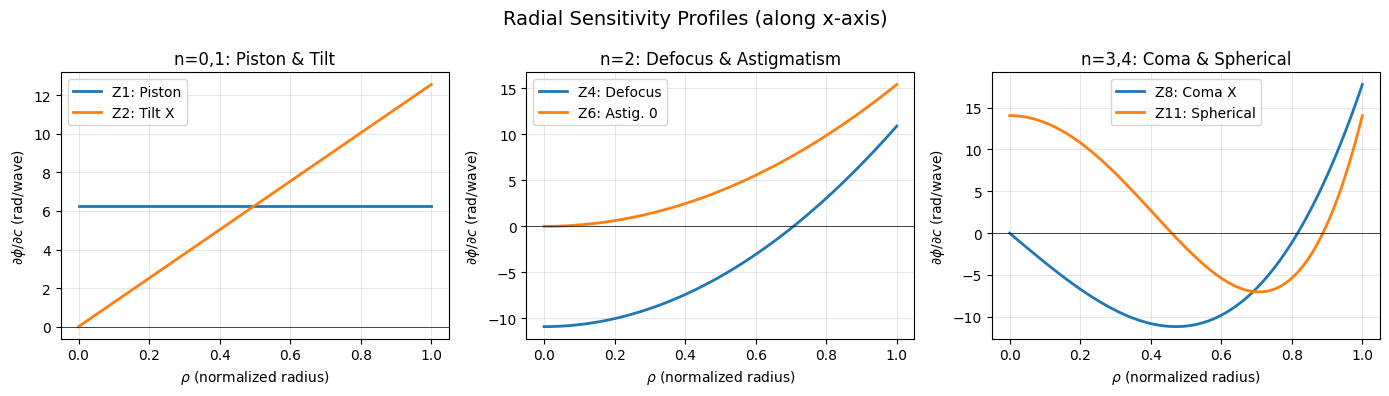

In [19]:
# Visualize how gradients change along a radial slice
# This shows the radial dependence of sensitivity to each coefficient

rho_slice = jnp.linspace(0, 1, 100)
theta_slice = 0.0  # Along x-axis

# Compute Zernike polynomials along the slice (these are the gradients scaled by 2*pi)
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Group by radial order
groups = [
    ("n=0,1: Piston & Tilt", [(1, "Piston"), (2, "Tilt X")]),
    ("n=2: Defocus & Astigmatism", [(4, "Defocus"), (6, "Astig. 0")]),
    ("n=3,4: Coma & Spherical", [(8, "Coma X"), (11, "Spherical")]),
]

for ax, (title, modes) in zip(axes, groups):
    for j, name in modes:
        n, m = noll_to_nm(j)
        n, m = int(n), int(m)  # Ensure Python int
        # Gradient is 2*pi * normalized_zernike
        Z = 2 * jnp.pi * zernike_polynomial(rho_slice, jnp.full_like(rho_slice, theta_slice), n, m, normalize=True)
        ax.plot(rho_slice, Z, label=f"Z{j}: {name}", linewidth=2)
    
    ax.set_xlabel(r"$\rho$ (normalized radius)")
    ax.set_ylabel(r"$\partial\phi / \partial c$ (rad/wave)")
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linewidth=0.5)

plt.suptitle("Radial Sensitivity Profiles (along x-axis)", fontsize=14)
plt.tight_layout()
plt.show()

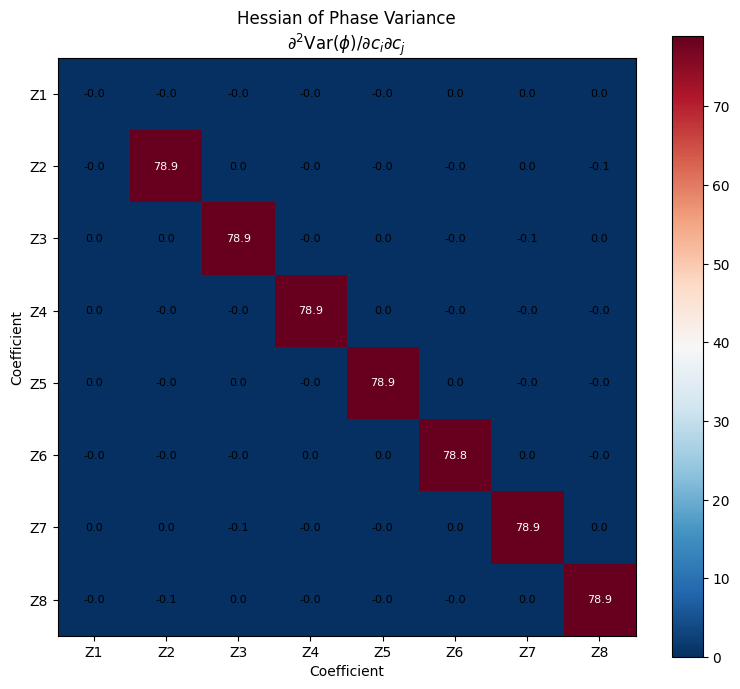

The diagonal Hessian shows how variance depends quadratically on each coefficient.
Off-diagonal terms are ~0 due to orthogonality of Zernike polynomials.


In [20]:
# Higher-order derivatives: Hessian of phase variance
# This demonstrates second-order differentiation capability

def compute_phase_map(coeffs):
    """Compute full phase map from coefficients."""
    phase = jnp.zeros_like(rho_phys)
    for j in range(1, len(coeffs) + 1):
        n, m = noll_to_nm(j)
        n, m = int(n), int(m)
        Z = zernike_polynomial(rho_phys, theta_phys, n, m, normalize=True)
        phase = phase + coeffs[j-1] * Z
    return 2 * jnp.pi * phase

def total_phase_variance(coeffs):
    """Compute variance of phase over the pupil."""
    phase = compute_phase_map(coeffs)
    mask = rho_phys <= 1.0
    phase_in_pupil = jnp.where(mask, phase, 0.0)
    n_pixels = jnp.sum(mask)
    mean_phase = jnp.sum(phase_in_pupil) / n_pixels
    variance = jnp.sum(jnp.where(mask, (phase - mean_phase)**2, 0.0)) / n_pixels
    return variance

# Compute Hessian
hessian_fn = jax.hessian(total_phase_variance)
coeffs_zero = jnp.zeros(8)
hessian_matrix = hessian_fn(coeffs_zero)

# Plot Hessian
fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(hessian_matrix, cmap="RdBu_r")
ax.set_xticks(range(8))
ax.set_yticks(range(8))
labels = [f"Z{j}" for j in range(1, 9)]
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel("Coefficient")
ax.set_ylabel("Coefficient")
ax.set_title("Hessian of Phase Variance\n$\\partial^2 \\mathrm{Var}(\\phi) / \\partial c_i \\partial c_j$")
plt.colorbar(im, ax=ax)

# Annotate
for i in range(8):
    for j in range(8):
        val = hessian_matrix[i, j]
        color = "white" if abs(val) > jnp.max(jnp.abs(hessian_matrix)) * 0.5 else "black"
        ax.text(j, i, f"{val:.1f}", ha="center", va="center", color=color, fontsize=8)

plt.tight_layout()
plt.show()

print("The diagonal Hessian shows how variance depends quadratically on each coefficient.")
print("Off-diagonal terms are ~0 due to orthogonality of Zernike polynomials.")

## Summary

This tutorial covered:

1. **Index conversion** between Noll and (n,m) indexing
2. **Radial polynomials** $R_n^{|m|}(\rho)$
3. **Individual Zernike polynomials** using `zernike_polynomial()`
4. **Zernike pyramid** organization by radial and azimuthal order
5. **Common aberrations**: defocus, astigmatism, coma, spherical, trefoil
6. **Generating aberrations** from coefficient arrays
7. **Coefficient variations** and their effects
8. **Orthogonality** verification
9. **Random aberrations** generation
10. **Differentiability**: gradients, Jacobians, and Hessians with JAX

### Key Functions

| Function | Description |
|----------|-------------|
| `noll_to_nm(j)` | Convert Noll index to (n, m) |
| `nm_to_noll(n, m)` | Convert (n, m) to Noll index |
| `zernike_polynomial(rho, theta, n, m)` | Generate single polynomial |
| `zernike_radial(rho, n, m)` | Radial component only |
| `generate_aberration_noll(xx, yy, coeffs, r)` | Phase from Noll coefficients |
| `generate_aberration_nm(xx, yy, n, m, coeffs, r)` | Phase from (n,m) coefficients |
| `defocus()`, `astigmatism()`, `coma()`, etc. | Convenience functions |

### Differentiability

All functions are compatible with JAX transformations:
- `jax.grad` - First derivatives
- `jax.jacfwd` / `jax.jacrev` - Jacobians
- `jax.hessian` - Second derivatives
- `jax.jit` - JIT compilation
- `jax.vmap` - Vectorization